# Optimal Delay-and-Subtract for 2-Mic Array (Implied Mic Spacing Calculation)

This notebook:
- Loads your 48kHz stereo WAV file (`input.wav`)
- Sweeps delay values to find the optimal one for suppressing the front direction
- Calculates the physical spacing between mics implied by this delay
- Outputs the processed result (`output_optimal.wav`)

*Left channel = front mic, Right channel = back mic*

In [74]:
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from tqdm import tqdm

# Constants
fs = 48000
c = 343  # Speed of sound (m/s)

# Load audio
input_file = 'input.wav'
# Read the file and resample to 16kHz if needed

audio, fs_loaded = librosa.load(input_file, sr=fs, mono=False)
audio = audio.T  # Transpose to shape (samples, channels)
assert fs_loaded == fs, f"File must be 48kHz! (found {fs_loaded})"
assert audio.shape[1] == 2, "File must be stereo (front=left, back=right)"

front = audio[:, 1]
back = audio[:, 0]
print(f"Loaded '{input_file}' ({audio.shape[0]/fs:.2f} seconds).")

Loaded 'input.wav' (29.67 seconds).


In [75]:
# Fractional delay function (linear interpolation)
def fractional_delay(sig, delay):
    idx = np.arange(len(sig))
    idx_delayed = idx - delay
    idx0 = np.floor(idx_delayed).astype(int)
    idx1 = idx0 + 1
    w1 = idx_delayed - idx0
    valid = (idx0 >= 0) & (idx1 < len(sig))
    y = np.zeros_like(sig)
    y[valid] = (1 - w1[valid]) * sig[idx0[valid]] + w1[valid] * sig[idx1[valid]]
    return y

100%|██████████| 2000/2000 [01:43<00:00, 19.37it/s]


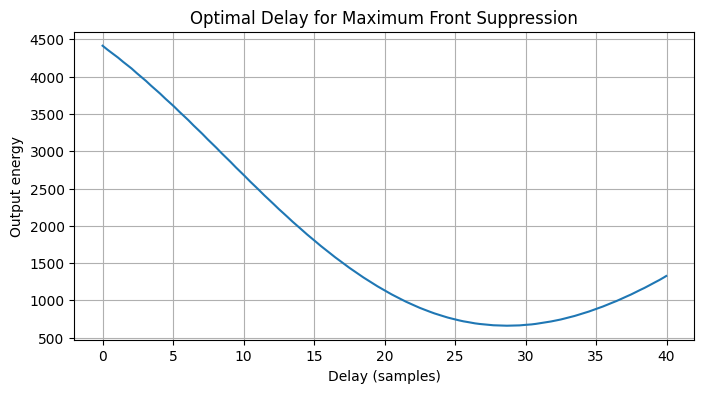

Optimal delay for suppression: 28.58 samples


In [76]:
# --- Delay Sweep for Optimal Front Suppression ---

min_delay = 0.0
max_delay = 40.0
step = 0.02
delays = np.arange(min_delay, max_delay, step)
energies = []

# Optional: focus on a region where only the front is active (edit as needed)
region = slice(int(2*fs), int(3*fs))   # or region = slice(start, end) for a segment

for dly in tqdm(delays):
    back_delayed = fractional_delay(back, dly)
    output = front - back_delayed
    seg = output[region]
    energy = np.sum(seg ** 2)
    energies.append(energy)

energies = np.array(energies)

plt.figure(figsize=(8,4))
plt.plot(delays, energies)
plt.xlabel("Delay (samples)")
plt.ylabel("Output energy")
plt.title("Optimal Delay for Maximum Front Suppression")
plt.grid()
plt.show()

optimal_delay = delays[np.argmin(energies)]
print(f"Optimal delay for suppression: {optimal_delay:.2f} samples")

In [77]:
# Calculate implied mic spacing d
delay_sec = optimal_delay / fs
d_estimated = delay_sec * c
print(f"Implied microphone spacing: {d_estimated*100:.1f} cm")



Implied microphone spacing: 20.4 cm


Optimal amplitude ratio K = 0.684
Written: output_optimal.wav


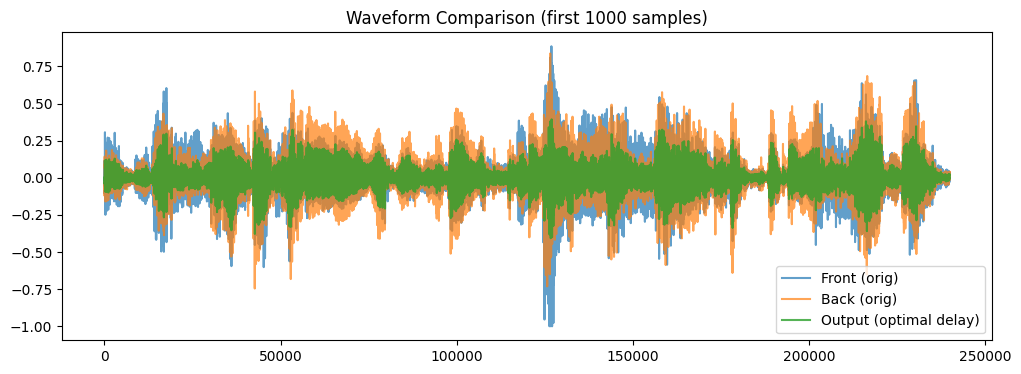

In [78]:
# Create and save processed audio with optimal delay
back_delayed_opt = fractional_delay(back, optimal_delay)

front_seg = front[region]
back_delayed_seg = back_delayed_opt[region]

numerator = np.sum(front_seg * back_delayed_seg)
denominator = np.sum(back_delayed_seg ** 2) + 1e-12  # Avoid divide by zero
K = numerator / denominator
print(f"Optimal amplitude ratio K = {K:.3f}")

output_opt = (front - K * back_delayed_opt) + (back_delayed_opt - K * front)
# Normalize to prevent clipping
maxval = np.max(np.abs(output_opt))
if maxval > 0.99:
    output_opt = 0.99 * output_opt / maxval

sf.write("output_optimal.wav", output_opt, fs)
print("Written: output_optimal.wav")

# Optional: compare waveforms visually
region=slice(15*fs, 20 * fs)
plt.figure(figsize=(12,4))
plt.plot(front[region], label="Front (orig)", alpha=0.7)
plt.plot(back[region], label="Back (orig)", alpha=0.7)
plt.plot(output_opt[region], label="Output (optimal delay)", alpha=0.8)
plt.legend()
plt.title("Waveform Comparison (first 1000 samples)")
plt.show()

In [79]:
# --- LMS Adaptive Filtering for Front Suppression ---  

def lms_filter(x, d, M=32, mu=0.01):
    # x: reference (front), d: desired (back)
    N = len(x)
    w = np.zeros(M)
    y = np.zeros(N)
    for n in range(M, N):
        x_vec = x[n-M:n][::-1]
        y[n] = np.dot(w, x_vec)
        e = d[n] - y[n]
        w = w + 2 * mu * e * x_vec
    return d - y  # output: residual (back with front adaptively suppressed)

# Apply LMS filter for adaptive suppression
output_lms = lms_filter(back, front, M=32, mu=0.01)
# Normalize to prevent clipping
maxval = np.max(np.abs(output_lms))
if maxval > 0.99:
    output_lms = 0.99 * output_lms / maxval
sf.write("output_lms.wav", output_lms, fs)
